In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import spinesTS
print(spinesTS.__version__)

0.3.15


In [3]:
from spinesTS.data import *
series_data = BuiltInSeriesData(print_file_list=False)
data = series_data['Electric_Production']  # series_data[0], it works, too
y_name = 'value'
print(type(data))

<class 'spinesTS.frame.DataTS'>


# plot data

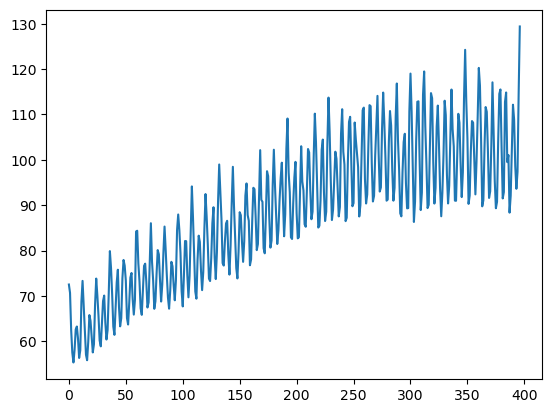

In [5]:
import matplotlib.pyplot as plt
data[y_name].plot()
plt.show()

# data preprocessing

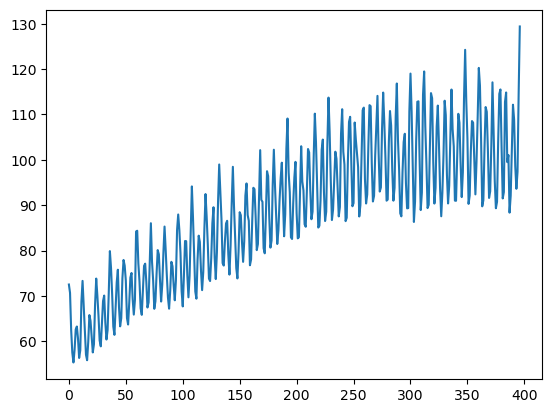

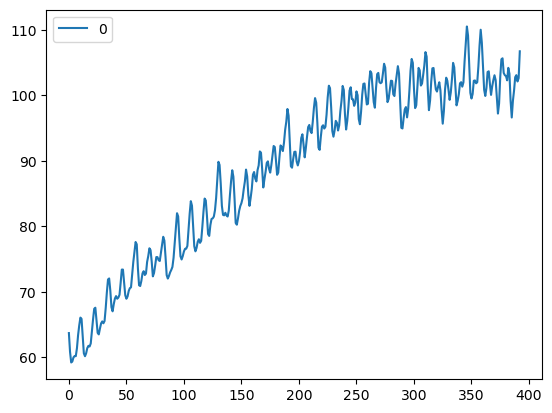

In [8]:
from spinesTS.preprocessing import moving_average
from spinesTS.data import DataTS
data[y_name].plot(), DataTS(moving_average(data[y_name], window_size=5)).plot()
plt.show()

# MultiForecast

In [9]:
from spinesTS.data import *
from spinesTS.preprocessing import split_series, train_test_split_ts
from spinesTS.ml_model import MultiOutputRegressor, MultiStepRegressor, DummyModel

from spinesTS.plotting import plot2d
from spinesTS.metrics import *
from lightgbm import LGBMRegressor
from spinesTS.features_generator import *

In [13]:
ds = data[y_name]
x_train, x_test, y_train, y_test = split_series(ds, ds, 128, 30, train_size=0.8)

In [14]:
msf_lgb = MultiStepRegressor(LGBMRegressor(linear_tree=True))

mof_lgb = MultiOutputRegressor(LGBMRegressor(linear_tree=True))

baseline = DummyModel()

In [15]:
msf_lgb.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=10, verbose=0)
mof_lgb.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=10, verbose=0)

baseline.fit(x_train, y_train)

y_pred_msf_lgb = msf_lgb.predict(x_test)
y_pred_mof_lgb = mof_lgb.predict(x_test)
y_pred_baseline = baseline.predict(x_test)
print('r2:', r2_score(y_test.T, y_pred_msf_lgb.T), r2_score(y_test.T, y_pred_mof_lgb.T), r2_score(y_test.T, y_pred_baseline.T))
print('mae:', mae(y_test, y_pred_msf_lgb), mae(y_test, y_pred_mof_lgb), mae(y_test, y_pred_baseline))
print('wmape:', wmape(y_test, y_pred_msf_lgb), wmape(y_test, y_pred_mof_lgb), wmape(y_test, y_pred_baseline))

r2: 0.850485555030637 0.8307644690502874 -1.0039332825306606
mae: 2.7800853759652564 2.911638585270947 10.690322152777778
wmape: 0.027078253399326704 0.02835959215527672 0.10412459080428259


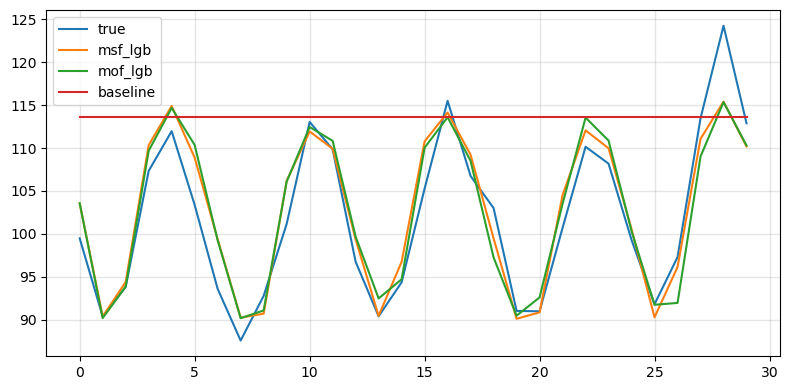

In [16]:
a = plot2d(y_test, y_pred_msf_lgb, y_pred_mof_lgb, y_pred_baseline,
           labels=['true', 'msf_lgb', 'mof_lgb', 'baseline'], 
           legend=True,
           figsize=(8, 4), eval_slices='[0]')

# Pipeline

In [17]:
from spinesTS.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [18]:
multi_reg = Pipeline([
    ('sc', StandardScaler()),
    ('multi_reg', MultiOutputRegressor(LGBMRegressor(linear_tree=True)))
])

In [19]:
multi_reg.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=10, verbose=0)

In [20]:
y_pred = multi_reg.predict(x_test)

In [21]:
r2_score(y_test.T, y_pred.T)

0.8281831309832475

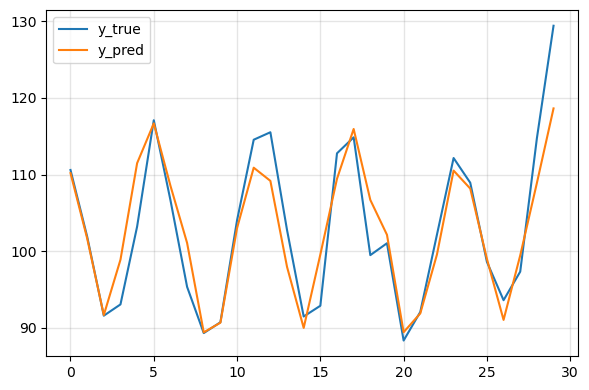

In [22]:
a = plot2d(y_test, y_pred, labels=['y_true', 'y_pred'], figsize=(6, 4), eval_slices='[-1]')

## other algorithm pipeline

In [23]:
from spinesTS.metrics import mean_absolute_error
from spinesTS.metrics import mean_absolute_percentage_error
from lightgbm import LGBMRegressor

In [24]:
multi_reg = Pipeline([
    ('sc', StandardScaler()),
    ('multi_reg', MultiOutputRegressor(LGBMRegressor(linear_tree=True)))
])
multi_reg.fit(x_train, y_train, eval_set=(x_test, y_test), early_stopping_rounds=10, verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mae(y_test, y_pred)}")
print(f"wmape: {wmape(y_test, y_pred)}")

r2: 0.8281831309832475
mae: 2.922530374452309
wmape: 0.028465679051015505


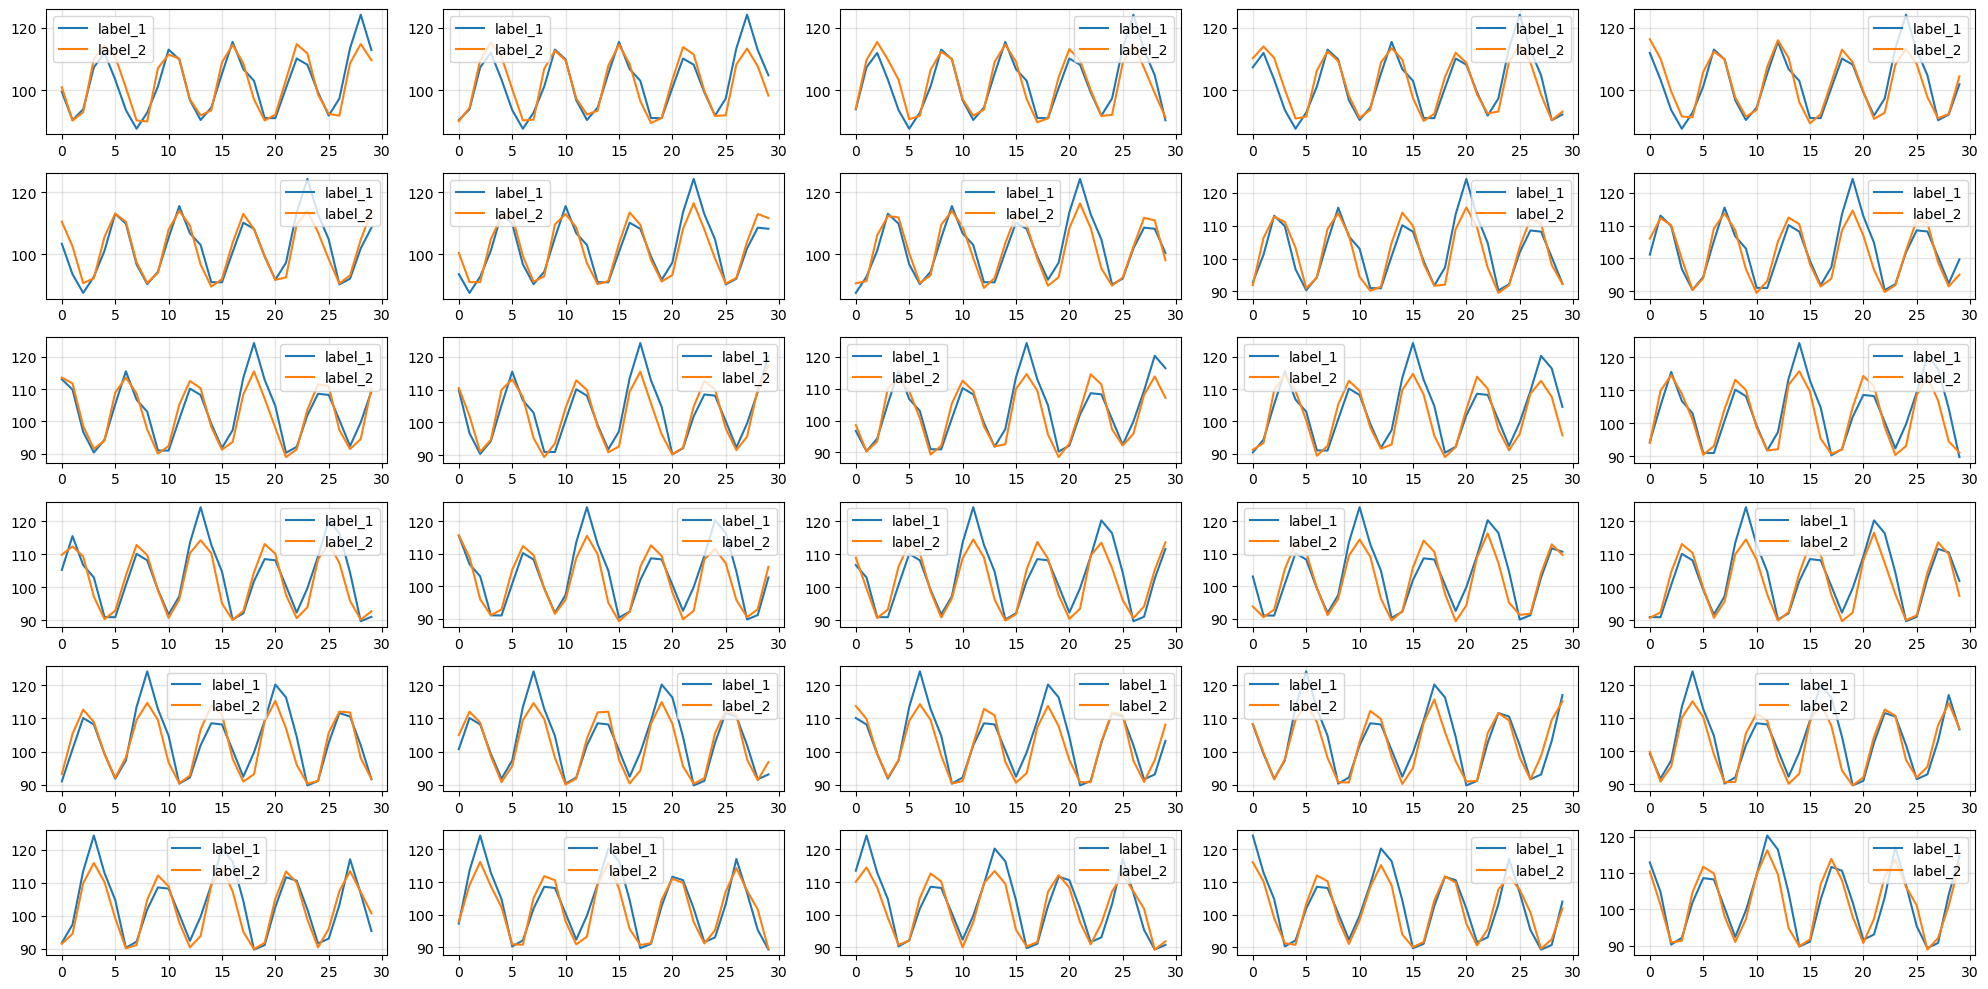

In [25]:
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[:30]')

## feature generate

r2: 0.8309424680952501
mae: 2.9217201034428646
wmape: 0.0284577869467278


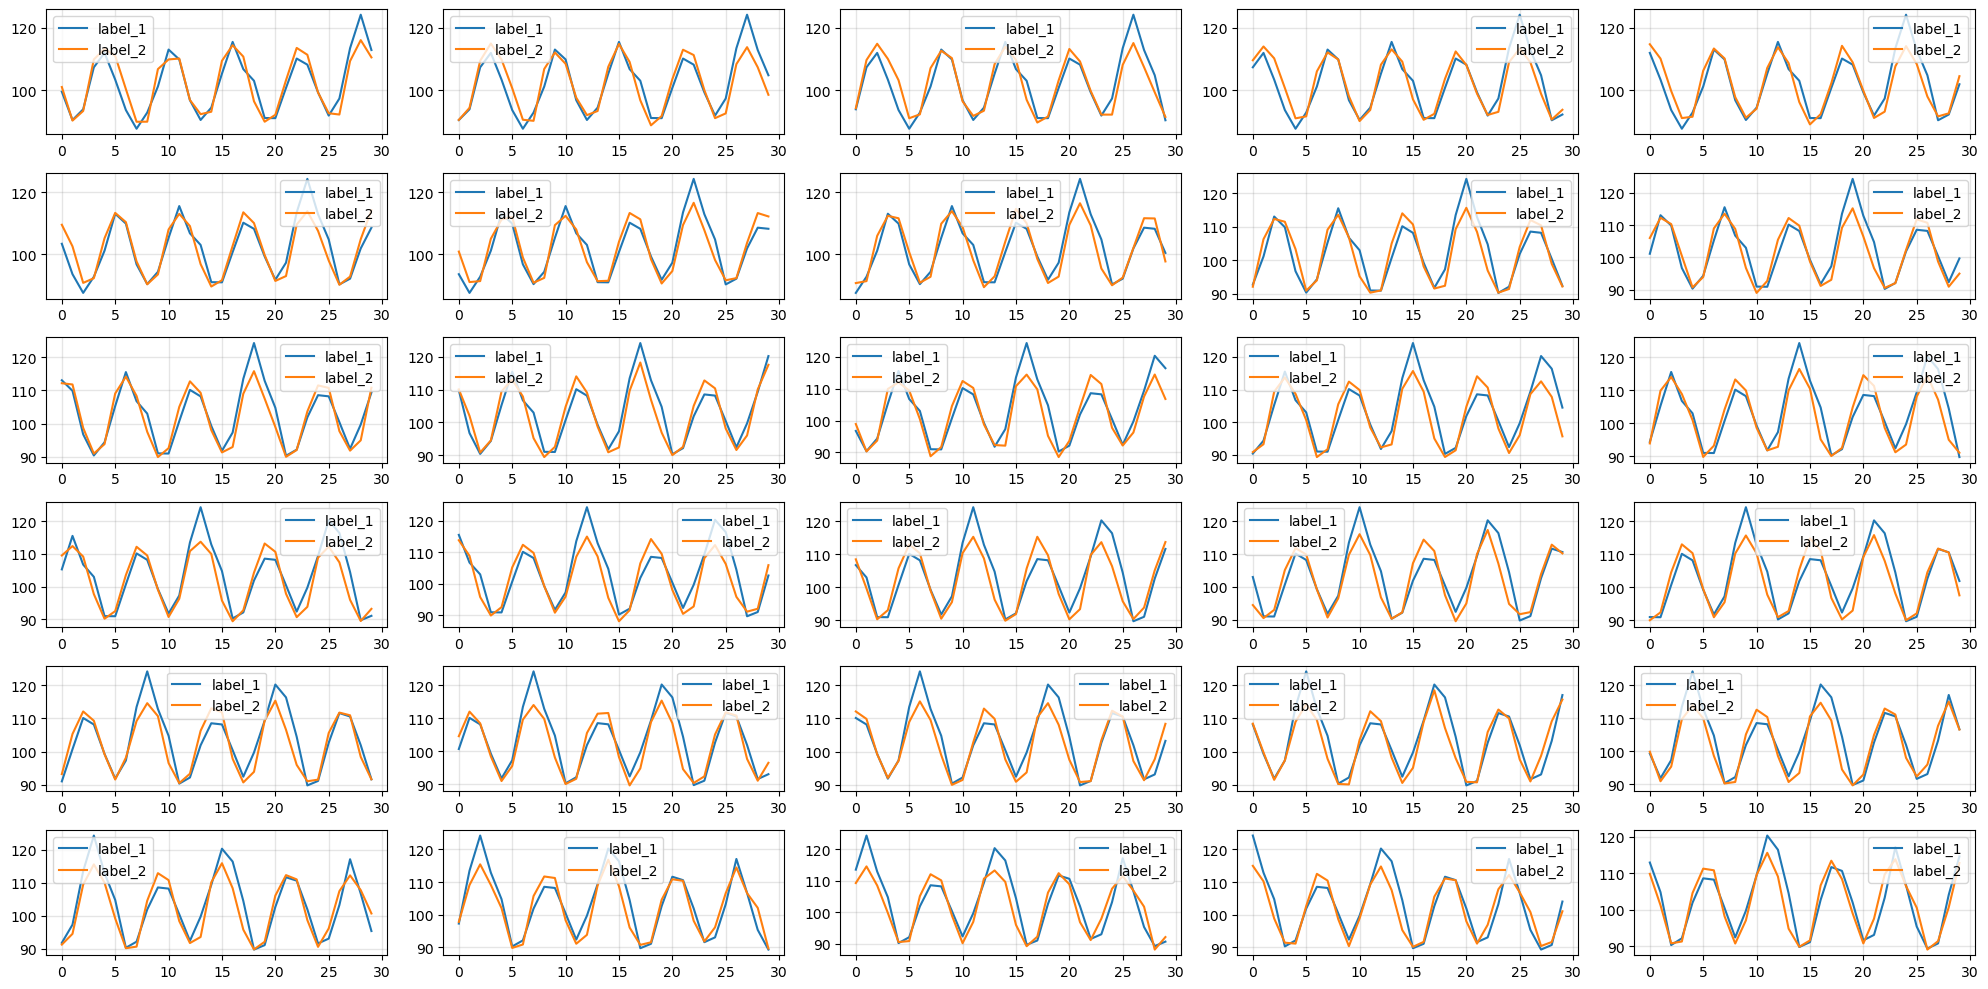

In [26]:
from spinesTS.features_generator import ContinuousFeatureGenerator

multi_reg = Pipeline([
    ('fe', ContinuousFeatureGenerator()),
    ('sc', StandardScaler()),
    ('multi_reg', MultiOutputRegressor(LGBMRegressor(linear_tree=True)))
])
multi_reg.fit(x_train, y_train, eval_set=([x_test, y_test]), early_stopping_rounds=10, verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mae(y_test, y_pred)}")
print(f"wmape: {wmape(y_test, y_pred)}")
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[:30]')

r2: 0.8336002253248544
mae: 2.9200379693605285
wmape: 0.028441402826539643


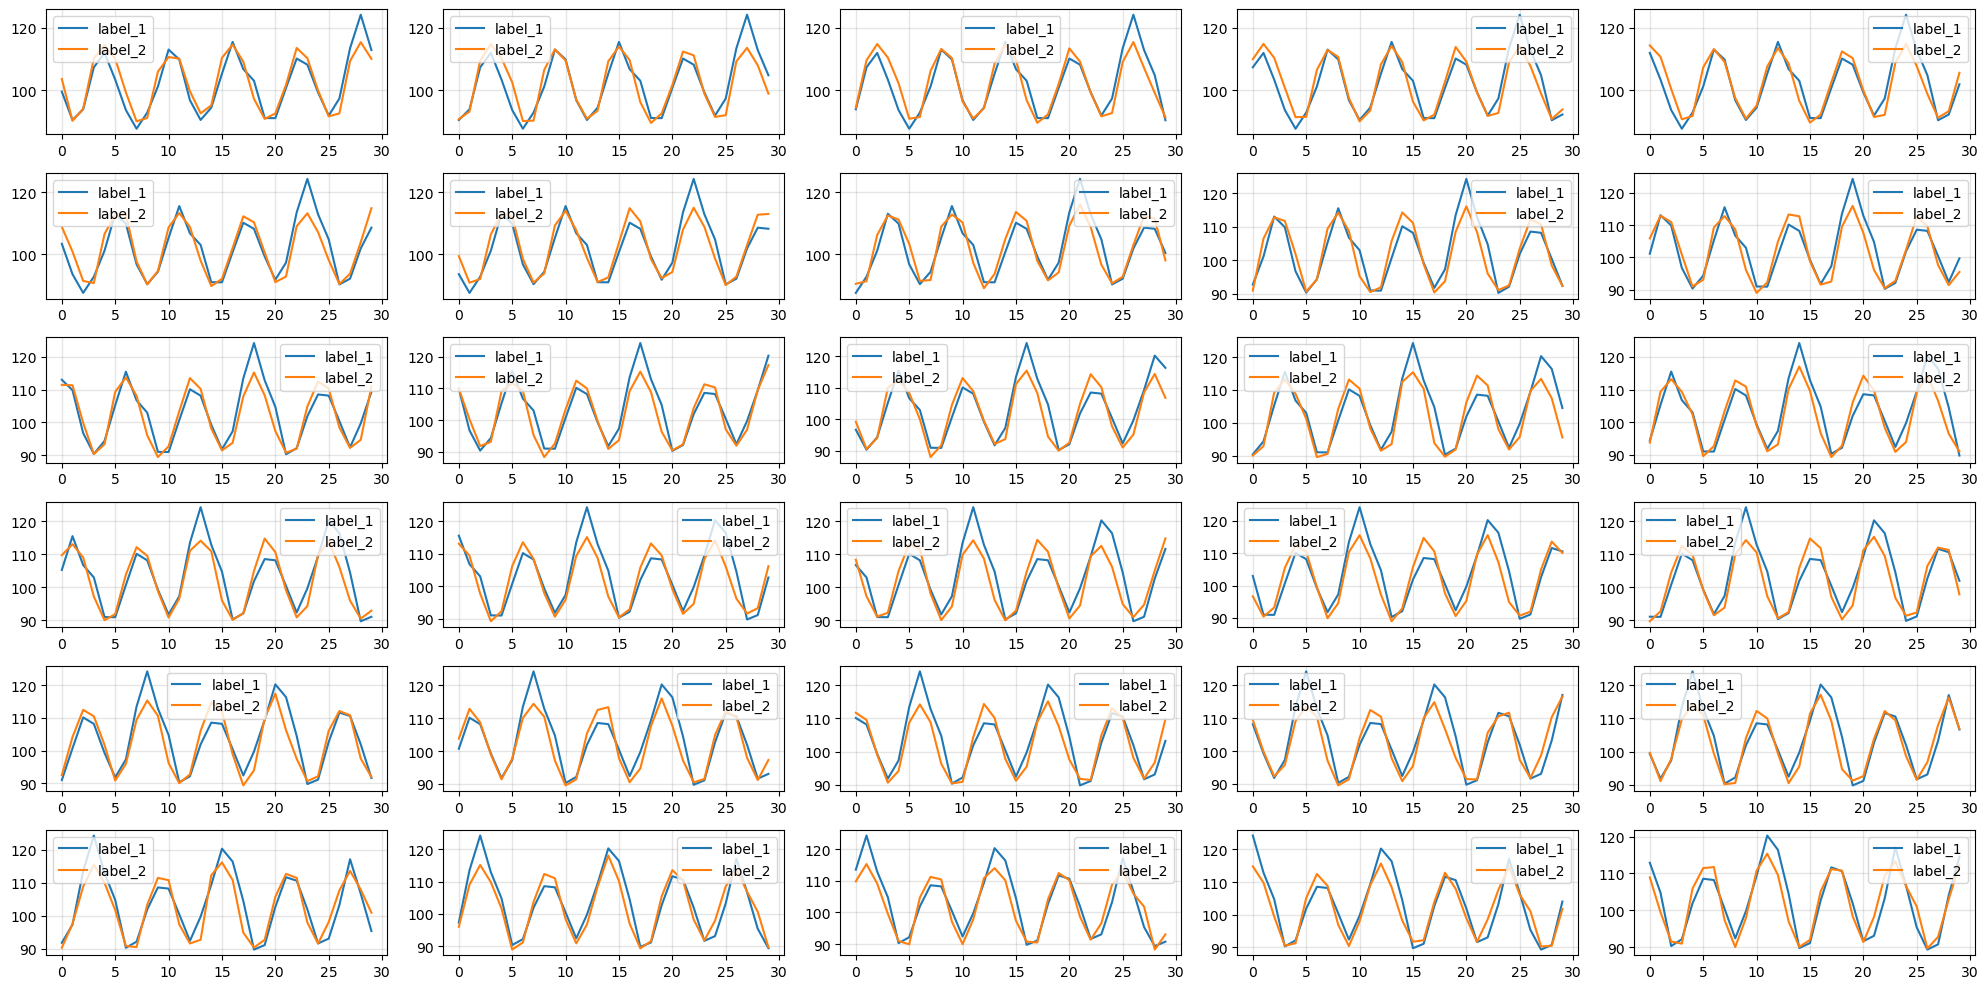

In [27]:
from spinesTS.metrics import *
from spinesTS.features_generator import ContinuousFeatureGenerator

multi_reg = Pipeline([
    ('fe', ContinuousFeatureGenerator()),
    ('multi_reg', MultiOutputRegressor(LGBMRegressor(linear_tree=True)))
])
multi_reg.fit(x_train, y_train, eval_set=([x_test, y_test]), early_stopping_rounds=10, verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mae(y_test, y_pred)}")
print(f"wmape: {wmape(y_test, y_pred)}")
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[:30]')

# WideGBRT

In [3]:
from spinesTS.ml_model import GBRTPreprocessing, WideGBRT
from lightgbm import LGBMRegressor
from spinesTS.plotting import *
from spinesTS.data import LoadMessagesSentDataSets

In [4]:
gbrt_data = LoadMessagesSentDataSets()[['date', 'ta']]
gbrt_data

,date,ta
0,2020-01-01,194343
1,2020-01-02,207725
2,2020-01-03,179798
3,2020-01-04,196651
4,2020-01-05,206737
...,...,...
597,2021-08-20,123051
598,2021-08-21,175442
599,2021-08-22,169774
600,2021-08-23,159922


In [8]:
from spinesTS.metrics import *
from lightgbm import early_stopping

gbrt_processor = GBRTPreprocessing(60, 40, 'ta', date_col='date', 
                                   differential_n=0, train_size=0.8, moving_avg_n=0,
                                  extend_daily_target_features=False)
gbrt_processor.fit(gbrt_data)
x_train, x_test, y_train, y_test = gbrt_processor.transform(gbrt_data)

wide_gbrt = WideGBRT(model=LGBMRegressor(linear_tree=True, verbosity=-1))
wide_gbrt.fit(x_train, y_train, eval_set=([x_test, y_test]), callbacks=[early_stopping(stopping_rounds=10, verbose=False)])
y_pred = wide_gbrt.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mae(y_test, y_pred)}")
print(f"wmape: {wmape(y_test, y_pred)}")

r2: -2.239805492060652
mae: 39521.6739366789
wmape: 0.2785187180774449


r2: -1.036833917243394
mae: 29614.379707981556
wmape: 0.21332602031971823


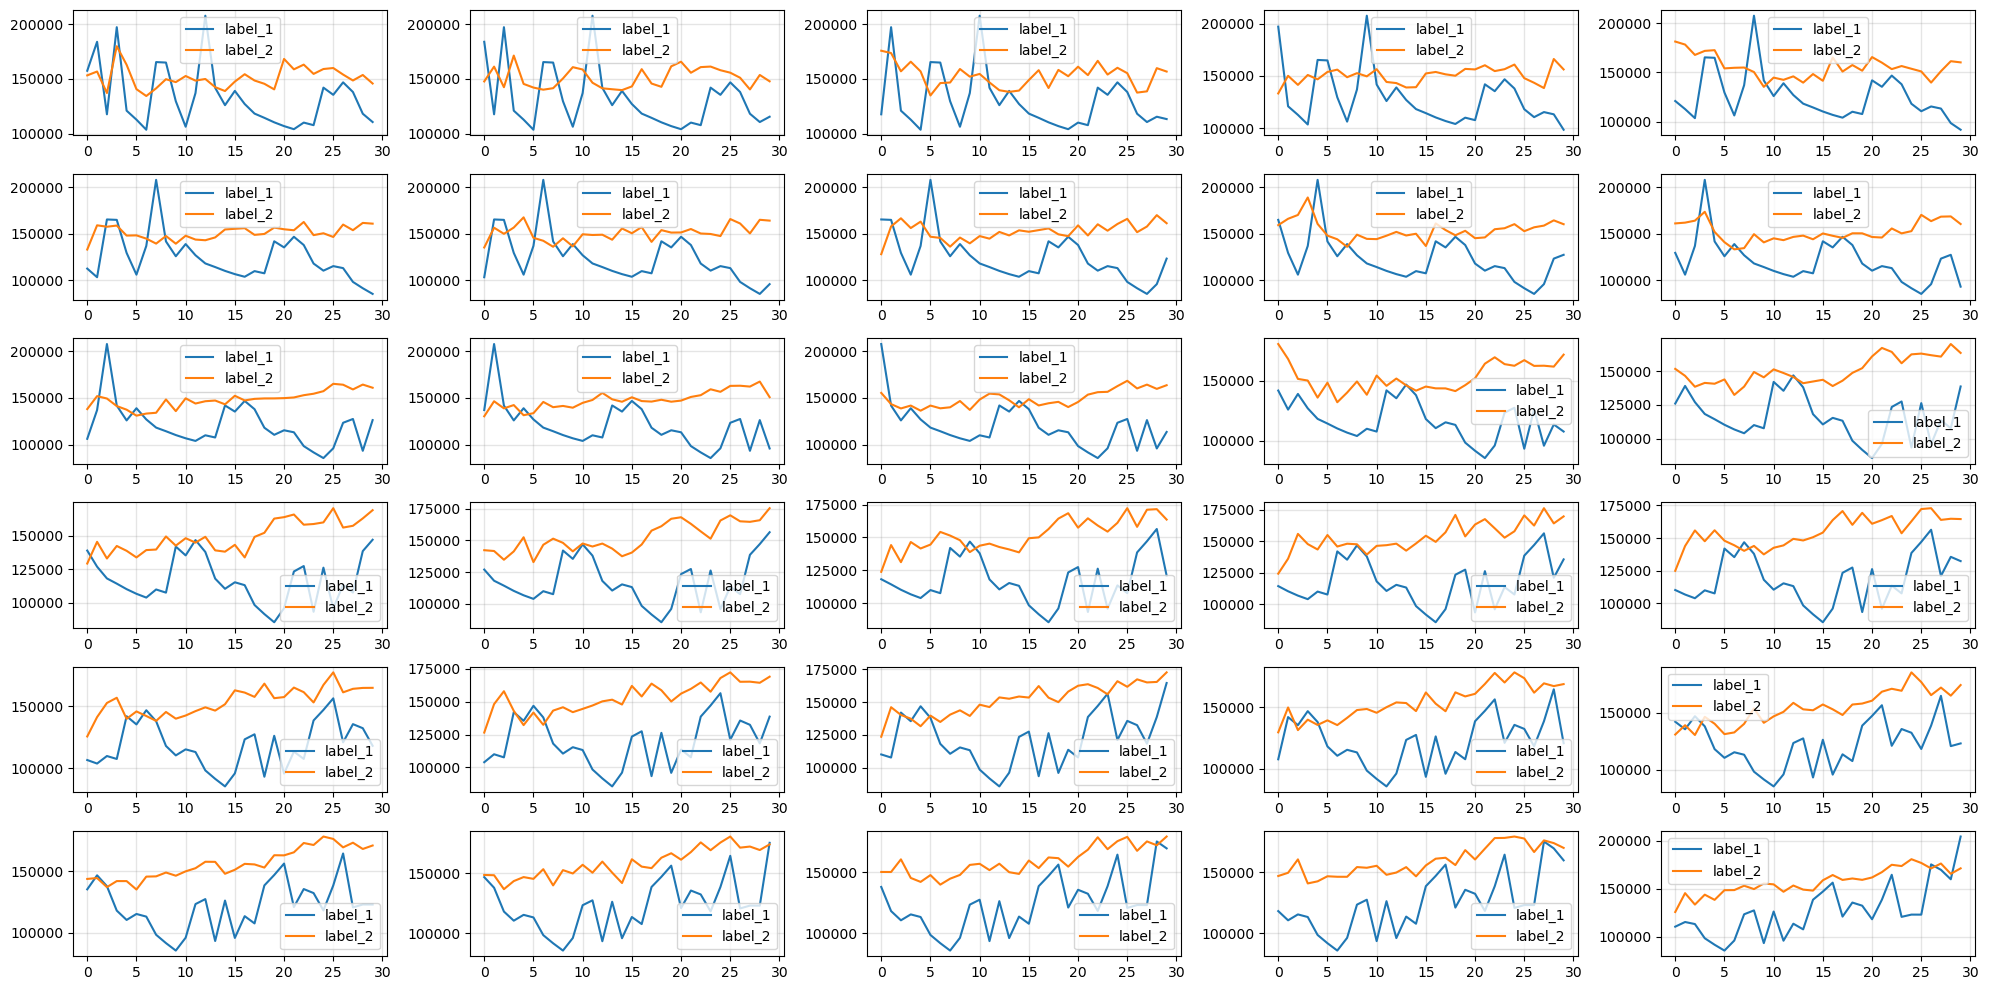

In [6]:
from spinesTS.metrics import *

gbrt_processor = GBRTPreprocessing(128, 30, 'ta', date_col='date', differential_n=0, 
                                   train_size=0.8, moving_avg_n=0, extend_daily_target_features=True)
gbrt_processor.fit(gbrt_data)
x_train, x_test, y_train, y_test = gbrt_processor.transform(gbrt_data)

from lightgbm.callback import early_stopping

wide_gbrt = WideGBRT(model=LGBMRegressor(linear_tree=False, verbosity=-1))
wide_gbrt.fit(x_train, y_train, eval_set=([x_test, y_test]), callbacks=[early_stopping(stopping_rounds=10, verbose=False)])
y_pred = wide_gbrt.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mae(y_test, y_pred)}")
print(f"wmape: {wmape(y_test, y_pred)}")
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[-30:]')

## AirPassengers dataset

In [25]:
series_data

+----+----------------------+----------------------------------------------------------------------+
|    | ds name              | columns                                                              |
+----+----------------------+----------------------------------------------------------------------+
|  0 | AirPassengers        | Month, #Passengers                                                   |
|  1 | ETTh1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  2 | ETTh2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  3 | ETTm1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  4 | ETTm2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  5 | Electric_Production  | date, value                                                          |
|  6 | M3_monthly_FTS       | series_id, method_id, forecast, horizon, timestamp, origin_ti

In [26]:
data = series_data['AirPassengers']
y_name = '#Passengers'
data

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


r2: 0.8251324914910395
mae: 22.847831398712835
mape: 0.054768390724603475


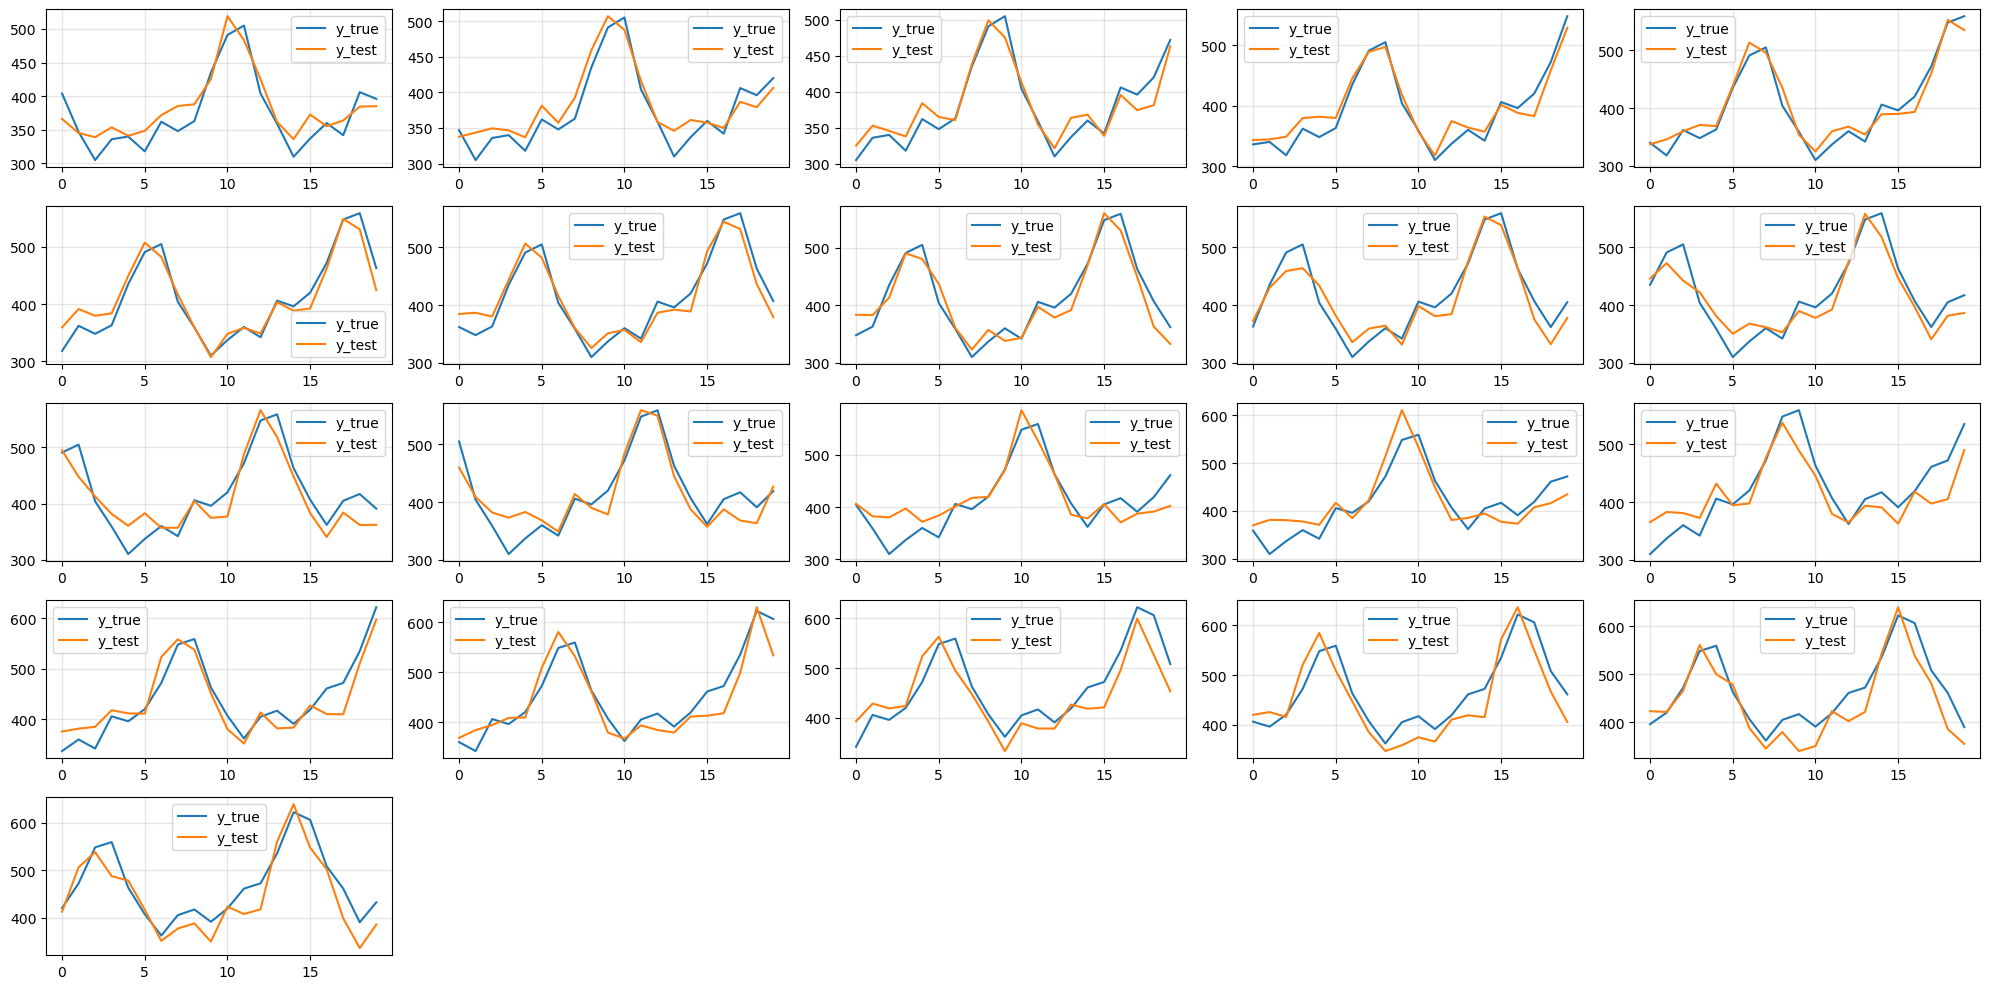

In [27]:
from spinesTS.ml_model import GBRTPreprocessing, WideGBRT
from lightgbm import LGBMRegressor
from spinesTS.plotting import *

gbrt_processor = GBRTPreprocessing(20, 20, y_name, date_col='Month', differential_n=1, train_size=0.8)
gbrt_processor.fit(data)

x_train, x_test, y_train, y_test = gbrt_processor.transform(data)

from spinesTS.metrics import *

wide_gbrt = WideGBRT(model=LGBMRegressor(linear_tree=True))
wide_gbrt.fit(x_train, y_train, eval_set=([x_test, y_test]), early_stopping_rounds=10, verbose=0)
y_pred = wide_gbrt.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[:30]', labels=['y_true', 'y_test'])